<a href="https://colab.research.google.com/github/umital/AGU-2021-module-data/blob/main/Mital_AGU_2021_AI_module_github.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# AI Learning Module: Hyperparameter Tuning and Interpretable AI
Author: Utkarsh Mital (umital@lbl.gov), Lawrence Berkeley National Laboratory<br>
Twitter: @utmital<br>
Acknowledgement: ExaSheds project funded by the U.S. Department of Energy, Office of Science, and Biological and Environmental Research under Contract No. DE-AC02-05CH11231.

## Background
**Hyperparameter tuning** refers to choosing a set of optimal hyperparameters for a machine learning model. These are distinct from model parameters as they are not learnt during training. A poor choice of hyperparameters can severely affect the ability of a model to make predictions. For neural nets, examples of hyperparameters include learning rate, number of hidden units, choice of activation functions and so on. <br>

**Interpretable AI/ML** refers to tools that can help a human better understand the cause of a decision made by a black-box model.<br>

In this notebook, we will go over some tools for hyperparameter tuning and interpretable ML. **I recommend that you run this notebook in google colab** as that is the only environment it has been tested in.




## Installing libraries
The following libraries are not installed in colaboratory by default, and need to be installed manually for the purpose of this learning activity.<br>

Note: on colab, you will get an error message while installing scikeras. You can safely ignore it; it does not hamper any of our activities.



In [ ]:
!pip install rasterio
!pip install geopandas
!pip install -q -U keras-tuner
!pip install scikeras
!pip install PyALE

     |████████████████████████████████| 19.3 MB 35.3 MB/s 
     |████████████████████████████████| 1.0 MB 5.2 MB/s 
     |████████████████████████████████| 15.4 MB 19.6 MB/s 
     |████████████████████████████████| 6.3 MB 45.6 MB/s 
     |████████████████████████████████| 98 kB 3.4 MB/s 
  Attempting uninstall: importlib-metadata
    Found existing installation: importlib-metadata 4.8.2
    Uninstalling importlib-metadata-4.8.2:
      Successfully uninstalled importlib-metadata-4.8.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
markdown 3.3.6 requires importlib-metadata>=4.4; python_version < "3.10", but you have importlib-metadata 3.10.1 which is incompatible.
     |████████████████████████████████| 275 kB 5.1 MB/s 
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283857 sha256=f1fab91f8b4137a93b7779c6cc2c978fd36d014a47920a63f123235b062

## Importing modules

The notebook requires the following modules

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import rasterio as rio
from rasterio.plot import show
from rasterio.plot import plotting_extent
import geopandas as gpd
import numpy as np
import time
import copy
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import validation_curve
from sklearn.model_selection import RandomizedSearchCV
from sklearn.inspection import partial_dependence
from scikeras.wrappers import KerasRegressor
from pprint import pprint
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.optimizers import Adam
import keras_tuner as kt
from PyALE import ale

sns.set(font_scale=1.35, style='whitegrid')

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## Data

Read in the data.

In [ ]:
DEM_raster = rio.open('AGU-2021-module-data/UCWRR_DEM_800m.tif')
US_raster = rio.open('AGU-2021-module-data/PRISM_us_dem_4km_bil/PRISM_us_dem_4km_bil.bil')

Metadata = pd.read_csv('AGU-2021-module-data/Metadata_processed.csv')
Metadata['StationID'] = Metadata['StationID'].apply(str)

stations_path = 'AGU-2021-module-data/NRCS_dates_2008_2017.csv'
stations_df = pd.read_csv(stations_path)

Metadata_gdf = gpd.GeoDataFrame(Metadata,
              geometry=gpd.points_from_xy(Metadata['Longitude'],
                                          Metadata['Latitude']))

## Study area
The highlighted box shows the Upper Colorado River Basin (UCRB) in western United States. UCRB drains into the Colorado River which is the primary source of water and jobs for close to 40 million people in southwestern United States and Mexico.

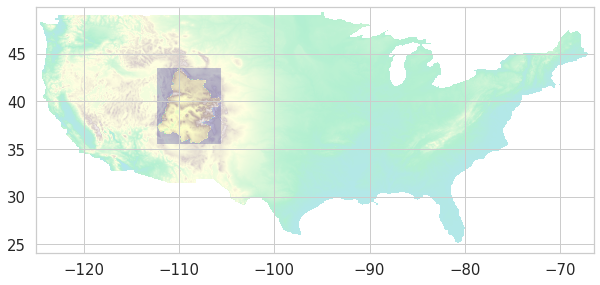

In [ ]:
fig, ax = plt.subplots(figsize=(10,10))
show(US_raster.read(1, masked=True), ax=ax, transform=US_raster.transform,
     cmap='terrain', alpha=0.3, vmin=-1000, vmax=4000)
show(DEM_raster.read(1, masked=False), ax=ax, transform=DEM_raster.transform,
     cmap='terrain', alpha=0.3, vmin=-1000, vmax=4000)
ax.set_xlim(US_raster.bounds.left, US_raster.bounds.right)
ax.set_ylim(US_raster.bounds.bottom, US_raster.bounds.top)
plt.show()

## Problem statement

To explore hyperparameter tuning and interpretable ML, we consider the following problem.<br><br>

As part of the National Resources Conservation Service (NRCS), the National Water and Climate Center maintains a database of weather station data with the purpose of disseminating water supply forecasts and climatic data. Using the [NRCS online portal](https://www.nrcs.usda.gov/wps/portal/wcc/home/), I downloaded precipitation data for stations in the Upper Colorado Basin, for the period of 2008-2017. The precipitation data are stored in the variable "stations_df", and the corresponding metadata are stored in the variable "Metadata_gdf". A quick analysis of the data tells us that close to 1/3 of the stations have incomplete records. We can use machine learning to gap-fill the incomplete records!

As an aside, note that the weather stations tend to be concentrated near higher elevations. This is because a large fraction of these weather stations also measure snowpack.

Total stations: 152
Stations with complete records: 97
Stations with incomplete records: 55


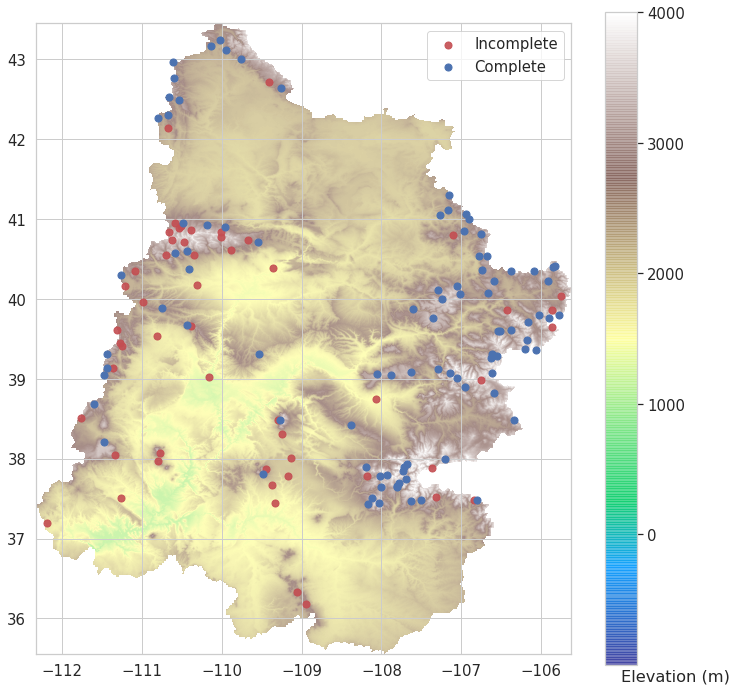

In [ ]:
## Segregate stations having complete and incomplete records ####
incomplete_stations = stations_df.count() < stations_df.shape[0]
complete_stations = stations_df.count() == stations_df.shape[0]
Complete_df = stations_df.loc[:,complete_stations]
Complete_df = Complete_df.iloc[:,4:] # first 4 columns are Date | Year | Month | Day
Incomplete_df = stations_df.loc[:,incomplete_stations]

## Additional quality control by setting any negative values to zero #####
Complete_df = Complete_df.mask(Complete_df < 0, 0.0)
Incomplete_df = Incomplete_df.mask(Incomplete_df < 0, 0.0)

## plot all the stations, and color code them depending on whether they have complete/incomplete records
fig, ax = plt.subplots(figsize=(12,12))
sns.set(font_scale=1.35, style='whitegrid')
plt.imshow(DEM_raster.read(1, masked=True), cmap='terrain', alpha=0.7, vmin=-1000, vmax=4000)
Metadata_gdf[Metadata_gdf['StationID'].isin(Incomplete_df.columns)].plot(ax=ax, color='C3', alpha=0.9, markersize=50, label='Incomplete')
Metadata_gdf[Metadata_gdf['StationID'].isin(Complete_df.columns)].plot(ax=ax, color='C0', markersize=50, label='Complete')
show(DEM_raster.read(1, masked=True), ax=ax, cmap='terrain', transform=DEM_raster.transform, alpha=0.7, vmin=-1000, vmax=4000)
cbar = plt.colorbar()
cbar.set_ticks([0, 1000, 2000, 3000, 4000])
cbar.ax.set_xlabel('Elevation (m)', ha='left')
plt.legend()

print (f'Total stations: {stations_df.shape[1] - 4}') # first 4 columns are Date | Year | Month | Day
print (f'Stations with complete records: {Complete_df.shape[1]}')
print (f'Stations with incomplete records: {Incomplete_df.shape[1]}')

## Truncated dataset

In the interest of speeding things up, let us consider a smaller subset of stations in UCRB. Specifically, let us consider a subset of 20 stations picked randomly from the set of stations with complete records. Out of this subset, let us pretend that one station has an incomplete record and needs to be gap-filled. This will help us evaluate the effectiveness of ML-based gap-filling.

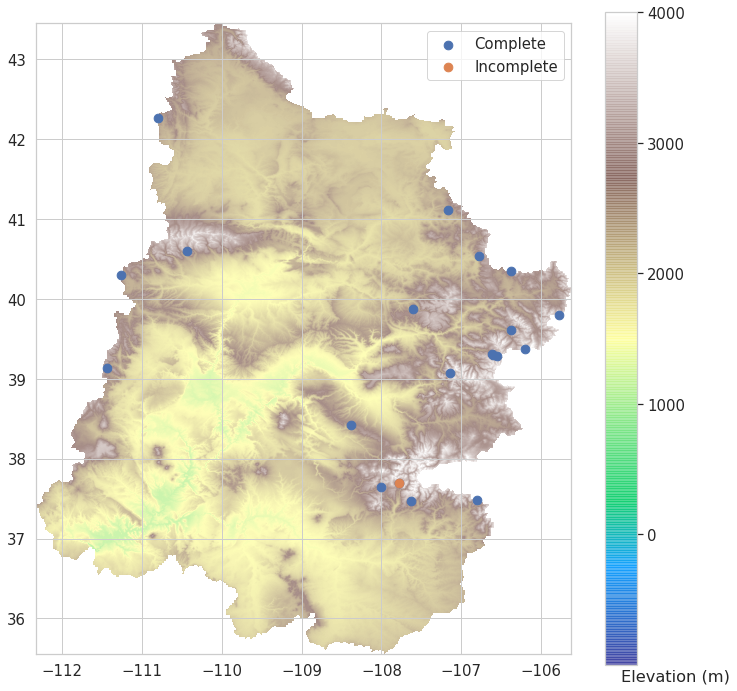

In [ ]:
np.random.seed(42) # for repeatability of results
subset_size = 20
random_indices = np.random.permutation(Complete_df.shape[1])[:subset_size]
stations_subset_df = Complete_df[Complete_df.columns[random_indices]]
Metadata_subset = Metadata_gdf[Metadata_gdf['StationID'].isin(stations_subset_df.columns)]

incomplete_index=4
Incomplete_stationID = stations_subset_df.columns[incomplete_index]


fig, ax = plt.subplots(figsize=(12,12))
sns.set(font_scale=1.35, style='whitegrid')
Metadata_subset.plot(ax=ax, color='C0', markersize=75, label='Complete')
Metadata_subset[Metadata_subset['StationID'] == Incomplete_stationID].plot(ax=ax,
                                          color='C1', markersize=75, label='Incomplete')

plt.imshow(DEM_raster.read(1, masked=True), cmap='terrain', alpha=0.7, vmin=-1000, vmax=4000)
show(DEM_raster.read(1, masked=True), ax=ax, cmap='terrain', transform=DEM_raster.transform, alpha=0.7, vmin=-1000, vmax=4000)
cbar = plt.colorbar()
cbar.set_ticks([0, 1000, 2000, 3000, 4000])
cbar.ax.set_xlabel('Elevation (m)', ha='left')
plt.legend()
plt.show()

## Gap-filling strategy

Now the fun begins! There are several strategies for gap-filling missing records ([Mital et al., 2020](https://www.frontiersin.org/article/10.3389/frwa.2020.00020/full)). The most promising approach involves using neighboring weather stations as the feature space, and then using those features to predict the missing values (labels). This is a form of ML-based spatial interpolation. Let us extract the features and labels from our dataset, and then split the dataset into training and test sets.



In [ ]:
nstations = subset_size
labels = stations_subset_df.iloc[:,incomplete_index]
features_indices = np.delete(np.arange(nstations), incomplete_index)
features = stations_subset_df.iloc[:,features_indices]
features_array = np.asarray(features)
labels_array = np.asarray(labels)

train_features, test_features, train_labels, test_labels = train_test_split(features_array,
                                          labels_array, test_size = 0.2, random_state = 42)


display(features)
display(labels)

,658,547,874,409,797,669,554,371,1030,485,739,566,457,556,335,435,378,842,732
0,2.54,0.00,2.54,0.00,0.00,2.54,0.00,2.54,7.62,0.00,0.00,0.00,2.54,0.00,5.08,0.00,0.00,5.08,0.00
1,2.54,2.54,7.62,0.00,2.54,2.54,0.00,2.54,2.54,5.08,0.00,0.00,0.00,0.00,2.54,0.00,2.54,2.54,0.00
2,2.54,5.08,5.08,5.08,0.00,2.54,2.54,0.00,2.54,0.00,2.54,0.00,2.54,5.08,0.00,5.08,2.54,5.08,0.00
3,2.54,2.54,2.54,2.54,2.54,2.54,2.54,5.08,0.00,2.54,0.00,2.54,0.00,2.54,0.00,0.00,2.54,0.00,2.54
4,0.00,0.00,2.54,5.08,2.54,2.54,2.54,0.00,2.54,0.00,2.54,7.62,0.00,2.54,2.54,7.62,2.54,2.54,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3648,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
3649,2.54,5.08,0.00,2.54,0.00,0.00,5.08,0.00,2.54,2.54,0.00,0.00,2.54,5.08,0.00,0.00,2.54,0.00,0.00
3650,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
3651,0.00,2.54,2.54,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00


0        0.00
1       17.78
2        0.00
3        2.54
4        5.08
        ...  
3648     0.00
3649     0.00
3650     0.00
3651     0.00
3652     0.00
Name: 780, Length: 3653, dtype: float64

We will use two popular ML algorithms: Random Forests and Neural Nets (multi-layer perceptrons). In order to fit these models to training data, we will briefly exploring tuning of hyperparameters.


## Hyperparameter tuning

Broadly, there are three popular algorithms for hyperparameter tuning:
1. Grid search
2. Randomized search
3. Bayesian optimization

Random search is more efficient than grid search ([Bergstra and Bengio, 2005](https://www.jmlr.org/papers/volume13/bergstra12a/bergstra12a)). Bayesian optimization uses results of earlier evaluations to determine which hyperparameter values to choose next. It is a sequential algorithm. In the interest of speed, we will use randomized search.



### Model evaluation metric
We will evaluate model performance computing the Nash-Sutciffe Efficiency ($NSE$) on test data:<br>
$NSE = 1 - MSE/\sigma^2$

Here, $MSE$ refers to the mean-squared error and $\sigma^2$ refers to the variance of observed (not modeled or predicted) data. Note that this is same as the model "score" that is evaluated for models in Python's sklearn module. $NSE$ varies from $-\infty$ to 1, with higher values ($>0$) being more desirable.

### Hyperparameters for Random Forests
Random Forests have four important parameters that need to be tuned ([Biau and Scornet, 2016](http://link.springer.com/10.1007/s11749-016-0481-7)). Following the naming conventions of sklearn, these are:
1. n_estimators: The number of trees in the forest.
2. max_features: The number of features to consider when looking for the best split
3. max_samples: the number of samples to train each decision tree.
4. min_samples_leaf: The minimum number of samples required to be at a leaf node.

Let us take a quick look at the effect of choosing different hyperparameters.








In [ ]:
rf_1 = RandomForestRegressor(random_state=42, max_features=1, min_samples_leaf=50)
rf_2 = RandomForestRegressor(random_state=42, max_features=10, min_samples_leaf=5)

rf_1.fit(train_features, train_labels)
rf_2.fit(train_features, train_labels)

print (rf_1.score(test_features, test_labels))
print (rf_2.score(test_features, test_labels))

0.4729964632980391
0.7810768733225972


### Define a search space for hyperparameter tuning

In [ ]:
# Number of trees in random forest
# n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = np.arange(1,20,1)
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = np.arange(2,26,3)
# Minimum number of samples required at each leaf node
min_samples_leaf = np.arange(1,11,2)

# Create the random grid
search_grid =  {'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf}


pprint(search_grid)

{'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None],
 'max_features': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19]),
 'min_samples_leaf': array([1, 3, 5, 7, 9]),
 'min_samples_split': array([ 2,  5,  8, 11, 14, 17, 20, 23])}


### Tune the RF hyperparameters using a random search

In [ ]:
start = time.time()

rf = RandomForestRegressor()

# Consider 50 different iterations, use 3-fold cross validation,
rf_search = RandomizedSearchCV(estimator = rf, param_distributions = search_grid, n_iter = 50, cv = 3, verbose=2, random_state=42, n_jobs = -1)

# Fit the model with the best parameters
rf_search.fit(train_features, train_labels)
print (f'NSE Score for the best model {rf_search.score(test_features, test_labels)}')
end = time.time()
print (f'Time elapsed: {end-start} seconds')

Fitting 3 folds for each of 50 candidates, totalling 150 fits
NSE Score for the best model 0.7810375992435169
Time elapsed: 41.46562194824219 seconds


In [ ]:
rf_search.best_params_

{'max_depth': 70,
 'max_features': 13,
 'min_samples_leaf': 3,
 'min_samples_split': 11}

### Hyperparameter tuning for neural networks

If you are building your neural network using the tensorflow/keras framework, you can use the KerasTuner framework. If you are building your network using Pytorch, you can use the Ray Tune framework. Other frameworks also exist (e.g., Adaptive Experimentation Platform [Ax], Weights & Biases)

In this activity, we will use the KerasTuner framework.

Before we proceed with neural nets, we need to normalize our input data.

In [ ]:
# Feature normalization
train_features_n = (train_features - train_features.mean(axis=0))/train_features.std(axis=0)
test_features_n = (test_features - train_features.mean(axis=0))/train_features.std(axis=0)

For simplicity, we consider a multilayer perceptron with a single hidden layer. But the workflow shown can be applied to any architecture. For more information, see the keras-tuner [getting started](https://keras.io/guides/keras_tuner/getting_started/) page.

Let's take a quick look at the impact of hyperparameters.

These are contrived examples but they illustrate how a poor choice of hyperparameters can impact the learning of a model.

In [ ]:
def NN_model_1():
    # create model
    model = Sequential()
    model.add(Dense(5, input_dim=train_features.shape[1], kernel_initializer='normal', activation='relu'))
    model.add(Dense(1, kernel_initializer='normal'))
    # Compile model
    model.compile(loss='mean_squared_error', metrics='mean_squared_error', optimizer=Adam(learning_rate=0.01))
    return model

def NN_model_2():
    # create model
    model = Sequential()
    model.add(Dense(500, input_dim=train_features.shape[1], kernel_initializer='normal', activation='linear'))
    model.add(Dense(1, kernel_initializer='normal'))
    # Compile model
    model.compile(loss='mean_squared_error', metrics='mean_squared_error', optimizer=Adam(learning_rate=0.1))
    return model

def get_NSE(model):
    nse = 1 - mean_squared_error(test_labels, model.predict(test_features_n))/np.var(test_labels)
    return nse

In [ ]:
model_1 = NN_model_1()
model_2 = NN_model_2()

start = time.time()
# Fit the model
model_1.fit(train_features_n, train_labels, epochs=50, batch_size=32, verbose=0)
model_2.fit(train_features_n, train_labels, epochs=50, batch_size=32, verbose=0)

end = time.time()
print (f'Time elapsed: {end-start} seconds')

Time elapsed: 17.113919734954834 seconds


In [ ]:
print (get_NSE(model_1))
print (get_NSE(model_2))

0.7785249596606437
0.5021337593000159


### Define search space for hyperparameter tuning

In [ ]:
def model_builder(hp):
  model = Sequential()

  # Tune the number of units in the first Dense layer
  hp_units = hp.Int('units', min_value=2, max_value=20, step=2)
  # Tune the activation function
  hp_activation = hp.Choice("activation", ['relu','linear', 'sigmoid'])
  # Tune the learning rate for the optimizer
  hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])

  model.add(Dense(units=hp_units, input_dim=train_features.shape[1],
                  kernel_initializer='normal', activation=hp_activation))
  model.add(Dense(1, kernel_initializer='normal'))
  model.compile(optimizer=Adam(learning_rate=hp_learning_rate),
                loss='mean_squared_error', metrics='mean_squared_error')

  return model

We use the "Hyperband" tuner.

Keras Tuner has three types of tuners - RandomSearch, Hyperband, BayesianOptimization. The Hyperband tuning algorithm is a special type of Random search that uses adaptive resource allocation and early-stopping to quickly converge on a high-performing model. This is done using a sports championship style bracket. The algorithm trains a large number of models for a few epochs and carries forward only the top-performing half of models to the next round. More information at [this hands-on tutorial](https://www.tensorflow.org/tutorials/keras/keras_tuner)

In [ ]:
tuner = kt.Hyperband(model_builder,
                     objective='val_mean_squared_error',
                     max_epochs=10,
                     factor=3,
                     overwrite=True,
                     project_name="NN_tuning_example",
                     )


tuner.search(train_features_n, train_labels, validation_split=0.2)

Trial 30 Complete [00h 00m 02s]
val_mean_squared_error: 60.49137878417969

Best val_mean_squared_error So Far: 12.867290496826172
Total elapsed time: 00h 00m 50s
INFO:tensorflow:Oracle triggered exit


tensorflow:INFO: Oracle triggered exit


In [ ]:
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"""
The optimal number of units in the densely-connected layer is {best_hps.get('units')},
optimal activation is {best_hps.get('activation')} and the optimal learning rate for the optimizer
is {best_hps.get('learning_rate')}.
""")


The optimal number of units in the densely-connected layer is 10, 
optimal activation is relu and the optimal learning rate for the optimizer
is 0.01.



### Create a model with the tuned values

In [ ]:
def NN_model_best():
    # create model
    model = Sequential()
    model.add(Dense(10, input_dim=train_features.shape[1], kernel_initializer='normal', activation='relu'))
    model.add(Dense(1, kernel_initializer='normal'))
    # Compile model
    model.compile(loss='mean_squared_error', metrics='mean_squared_error', optimizer=Adam(learning_rate=0.01))
    return model

In [ ]:
model_best = NN_model_best()
model_best.fit(train_features_n, train_labels, epochs=50, batch_size=32, verbose=0)
get_NSE(model_best)

0.7656607332761541

## Interpretable ML techniques

The entire section on interpretable ML is referenced from [Molnar (2019)](https://christophm.github.io/interpretable-ml-book/).

We will go over some model-agnostic methods for interpreting black-box models. In the spirit of using a black-box model, let's use a neural network.



### Create a neural net model compatible with sklearn

scikit-learn provides a number of tools for model interpretation. The scikeras module provides a wrapper around Keras/TensorFlow that has an sklearn interface. We can do this as follows:

In [ ]:
NN_estimator = KerasRegressor(model=NN_model_best,
                           loss='mean_squared_error',
                           epochs=50,
                           batch_size=32,
                           optimizer=Adam(0.01))

NN_estimator.fit(train_features_n, train_labels, verbose=0)

KerasRegressor(
	model=<function NN_model_best at 0x7feb265fcd40>
	build_fn=None
	warm_start=False
	random_state=None
	optimizer=<keras.optimizer_v2.adam.Adam object at 0x7feb220ef090>
	loss=mean_squared_error
	metrics=None
	batch_size=32
	validation_batch_size=None
	verbose=1
	callbacks=None
	validation_split=0.0
	shuffle=True
	run_eagerly=False
	epochs=50
)

In [ ]:
print (NN_estimator.score(test_features_n, test_labels))

23/23 [==============================] - 0s 1ms/step
0.7554960273685599




### Permutation Feature Importance ([Fisher et al., 2018](http://arxiv.org/abs/1801.01489))
Permutation feature importance measures the increase in prediction error or the model if we permute a feature's values. The greater the increase in error, the greater is the importance of the feature. The algorithm can be summarized as:
1. Estimate the original model error $e_{orig}$ (e.g., mean squared error)
2. For each feature $j$:
  - Generate a feature matrix by permuting feature $j$. This breaks the association between the feature $j$ and the true output.
  - Estimate the error $e_{perm}$ based on predictions of the permuted data
  - Calculate permutation feature importance as quotient $FI_j = e_{perm}/e_{orig}$ or difference $FI_j = e_{perm} - e_{orig}$

3. Sort the features in descending order of $FI$

It is recommended to use test data for computing feature importance. This is especially critical if the distributions of training data and test data are different. We want to know how important a feature is when it comes to making predictions on test data.

In [ ]:
original_error = mean_squared_error(test_labels, NN_estimator.predict(test_features_n))
perm_error_arr = np.zeros(test_features.shape[1])

for i in np.arange(test_features.shape[1]):
  test_features_copy = copy.deepcopy(test_features_n)
  np.random.shuffle(test_features_copy[:,i])
  perm_error = mean_squared_error(test_labels, NN_estimator.predict(test_features_copy))
  perm_error_arr[i] = np.round(perm_error - original_error, 2)

23/23 [==============================] - 0s 2ms/step


### Visualize the permutation importance

We see that weather stations closer to the station being modeled are ranked higher. This makes sense as stations that are physically closer will experience similar weather patterns (in this case, precipitation).

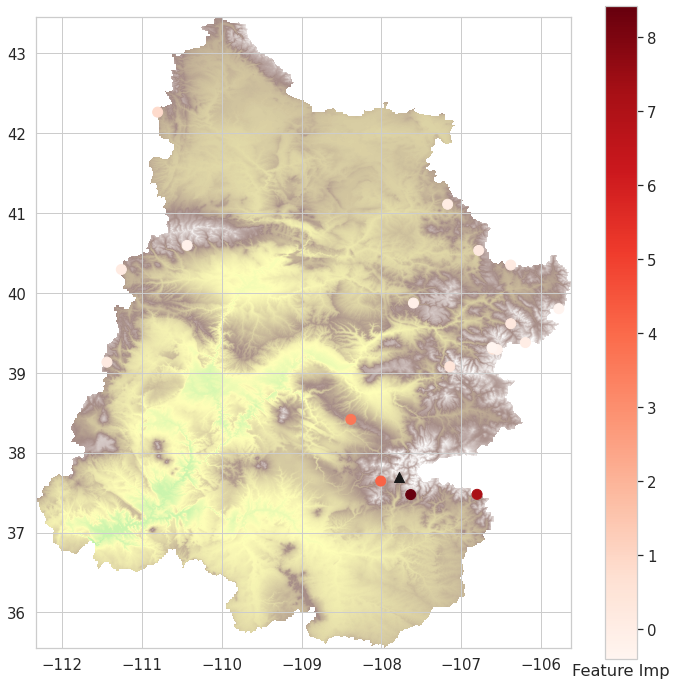

In [ ]:
Feat_Imp_df = pd.DataFrame({'StationID':features.columns, 'Imp':perm_error_arr})
Metadata_feat_imp_df = pd.merge(Feat_Imp_df,
                                Metadata_subset[Metadata_subset['StationID'].isin(features.columns)],
                                left_on='StationID', right_on='StationID')
fig, ax = plt.subplots(figsize=(12,12))
sns.set(font_scale=1.35, style='whitegrid')


Metadata_subset[Metadata_subset['StationID'] == Incomplete_stationID].plot(ax=ax, color='k', markersize=100, marker='^')

plt.scatter(Metadata_feat_imp_df['Longitude'], Metadata_feat_imp_df['Latitude'],
            c=Metadata_feat_imp_df['Imp'], cmap='Reds', s=100)


cbar1 = plt.colorbar()
cbar1.ax.set_xlabel('Feature Imp', ha='center')

plt.imshow(DEM_raster.read(1, masked=True), cmap='terrain', alpha=0.7, vmin=-1000, vmax=4000)
show(DEM_raster.read(1, masked=True), ax=ax, cmap='terrain', transform=DEM_raster.transform, alpha=0.7, vmin=-1000, vmax=4000)

In [ ]:
Feat_Imp_df.sort_values(by='Imp', ascending=False)

,StationID,Imp
4,797,8.41
2,874,7.14
10,739,4.15
3,409,3.65
6,554,0.85
5,669,0.46
0,658,0.40
17,842,0.26
12,457,0.23
7,371,0.18


### Partial Dependence Plot (PDP; [Freidman, 2001](https://www.jstor.org/stable/2699986))

A Partial Dependence Plot (PDP) shows the marginal effect that a feature has on the predicted outcome of a model. It can show if the relationship between the target and feature is linear, monotonic or more complex.

For regression models, the partial dependence function is defined as:

$\hat{f}_S (x_S) = E_{X_C} \left[\hat{f}(x_S, X_C)\right] $

$x_S$ is the feature for which we obtain a PDP and $X_C$ are the other features used in the machine learning model $\hat{f}$. The partial dependence for $x_S$ is estimated on the training data using a Monte Carlo approach:

$\hat{f}_S (x_S) = \dfrac{1}{n} \sum_{i=1}^n \hat{f}(x_S, x_C^i) $

$x_C^i$ are feature values from the dataset for the features we are *not* interested in, and $n$ is the numbers of instances in the dataset. We consider all the instances of our data, and replace the true value of $x_S$ with a realization of $x_S$ instead. We can then find the average model prediction for a given realization of $x_S$.

Let's run a quick example and visualize the PDP for a feature. I am picking the most important feature (as obtained via permutation importance).


In [ ]:
feature_ind = 4
pdp_data = partial_dependence(NN_estimator, train_features_n, [feature_ind], kind='average')

92/92 [==============================] - 0s 1ms/step


Text(0, 0.5, 'Averaged precip')

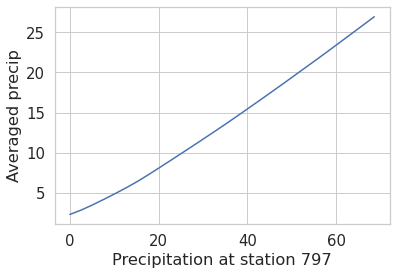

In [ ]:
unscaled_feature = (pdp_data['values'][0] * train_features.std(axis=0)[feature_ind]) + train_features.mean(axis=0)[feature_ind]

plt.plot(unscaled_feature, pdp_data['average'][0])

# plt.plot(raw_data[1][0].flatten(), raw_data[0].flatten())

plt.xlabel(f'Precipitation at station {features.columns[feature_ind]}')
plt.ylabel(f'Averaged precip')

Text(0, 0.5, 'Target precip')

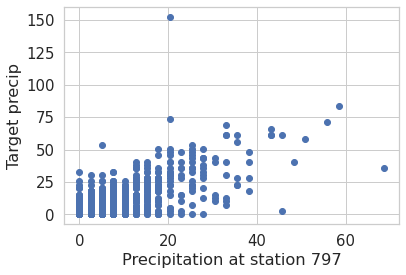

In [ ]:
plt.scatter(stations_subset_df[features.columns[feature_ind]], stations_subset_df[Incomplete_stationID])
plt.xlabel(f'Precipitation at station {features.columns[feature_ind]}')
plt.ylabel(f'Target precip')

### Individual Conditional Expectation (ICE; [Goldstein et al., 2015](https://doi.org/10.1080/10618600.2014.907095))

PDP helps estimate the average effect of a feature. An individual conditional expectation (ICE) plot is similar to PDP but helps visualize the effect of a feature for each instance separately. In our example, we see that there is an averaged linear trend, but a lot of variations are getting averaged out. Precipitation at the target station does not always increase with increase in precipitation at station 797.

In ICE plots, for each instance in $\left \lbrace (x_S^{(i)}, x_C^{(i)} ) \right \rbrace_{i=1}^N $, the curve $\hat{f_S}^{(i)}$ is plotted against $x_S^{(i)}$ while $x_C^{(i)}$ remains fixed.

The average of ICE plots results in a PDP.

Let's see how it looks for the same feature as above.

In [ ]:
ice_data = partial_dependence(NN_estimator, train_features_n, [feature_ind], kind='individual')

92/92 [==============================] - 0s 1ms/step


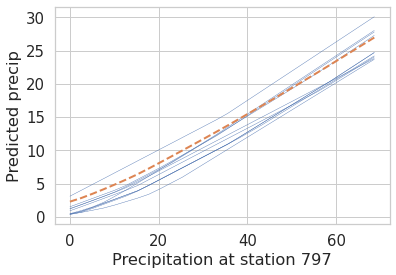

In [ ]:
unscaled_feature = (ice_data['values'][0] * train_features.std(axis=0)[feature_ind]) + train_features.mean(axis=0)[feature_ind]
plt.plot(unscaled_feature, ice_data['individual'][0].T[:,70:80], c='C0', linewidth=0.4)
plt.plot(unscaled_feature, pdp_data['average'][0], '--C1', linewidth=2)
plt.xlabel(f'Precipitation at station {features.columns[feature_ind]}')
plt.ylabel(f'Predicted precip')

plt.show()

### Accumulated Local Effects (ALE; [Apley and Zhu, 2020](https://doi.org/10.1111/rssb.12377))

PDP may not provide a trustworthy picture if features are strongly correlated. That is definitely true in our case (see feature correlation heatmap below). Accumulate local effects (ALE) are a faster and unbiased alternative to PDPs.

Limitation of a PDP: To generate a PDP, we create artificial instances of data. If the feature of interest is strongly correlated to another feature, then we may create artificial instances that are unlikely in reality.

(array([ 0.5,  1.5,  2.5,  3.5,  4.5,  5.5,  6.5,  7.5,  8.5,  9.5, 10.5,
        11.5, 12.5, 13.5, 14.5, 15.5, 16.5, 17.5, 18.5]),
 <a list of 19 Text major ticklabel objects>)

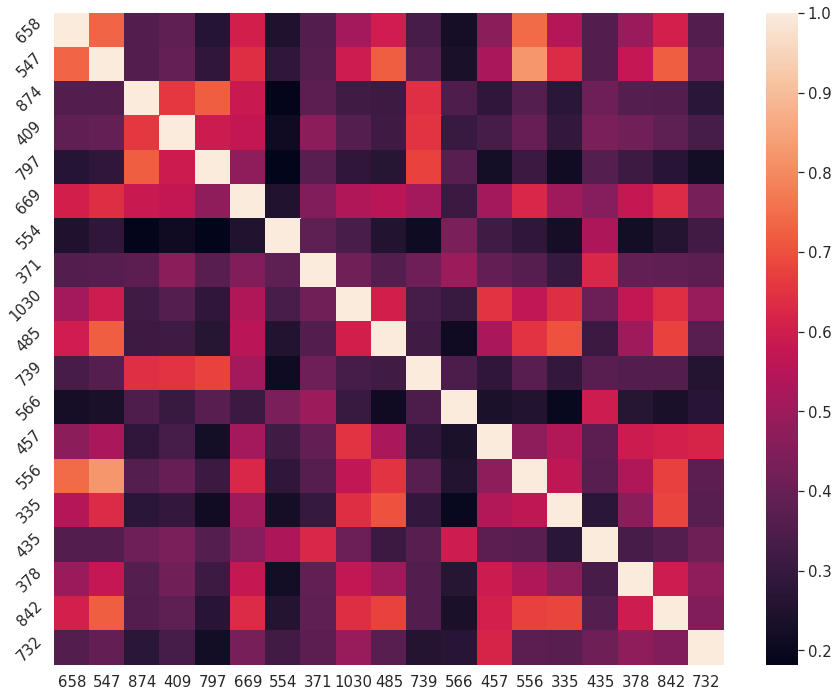

In [ ]:
fig, ax = plt.subplots(figsize=(15,12))
sns.heatmap(features.corr())
plt.yticks(rotation=45)

In [ ]:
features

,658,547,874,409,797,669,554,371,1030,485,739,566,457,556,335,435,378,842,732
0,2.54,0.00,2.54,0.00,0.00,2.54,0.00,2.54,7.62,0.00,0.00,0.00,2.54,0.00,5.08,0.00,0.00,5.08,0.00
1,2.54,2.54,7.62,0.00,2.54,2.54,0.00,2.54,2.54,5.08,0.00,0.00,0.00,0.00,2.54,0.00,2.54,2.54,0.00
2,2.54,5.08,5.08,5.08,0.00,2.54,2.54,0.00,2.54,0.00,2.54,0.00,2.54,5.08,0.00,5.08,2.54,5.08,0.00
3,2.54,2.54,2.54,2.54,2.54,2.54,2.54,5.08,0.00,2.54,0.00,2.54,0.00,2.54,0.00,0.00,2.54,0.00,2.54
4,0.00,0.00,2.54,5.08,2.54,2.54,2.54,0.00,2.54,0.00,2.54,7.62,0.00,2.54,2.54,7.62,2.54,2.54,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3648,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
3649,2.54,5.08,0.00,2.54,0.00,0.00,5.08,0.00,2.54,2.54,0.00,0.00,2.54,5.08,0.00,0.00,2.54,0.00,0.00
3650,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
3651,0.00,2.54,2.54,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00


For example, to obtain the effect on predictions for a feature value of $2.54$, the ALE method will use all data instances where the feature value is close to $2.54$. It will then compute model predictions pretending the feature has a value of $2.54 + \Delta $, minus predictions pretending the feature has a value of $2.54 - \Delta$.

To estimate the effect of a feature at a certain grid value $v$, we look at how the model predictions change in a small "window" of the feature around $v$ for data instances in that window.

We implement it using the PyALE module.

92/92 [==============================] - 0s 1ms/step


Text(0.5, 0, '797')

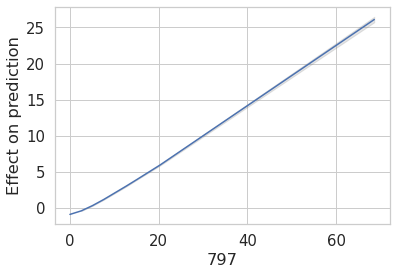

In [ ]:
train_features_n_df = pd.DataFrame(train_features_n, columns=features.columns)
test_features_n_df = pd.DataFrame(test_features_n, columns=features.columns)

# feature_ind=8
ale_eff = ale(
    X=train_features_n_df, model=NN_estimator, feature=[features.columns[feature_ind]],
    feature_type='continuous', grid_size=50, include_CI=True, plot=False
)

unscaled_feature = (ale_eff.index * train_features.std(axis=0)[feature_ind]) + train_features.mean(axis=0)[feature_ind]

plt.plot(unscaled_feature, ale_eff['eff'])
plt.fill_between(unscaled_feature,  ale_eff['lowerCI_95%'], ale_eff['upperCI_95%'],
                 color='gray', alpha=0.2)

plt.ylabel('Effect on prediction')
plt.xlabel(features.columns[feature_ind])

## Conclusion

This brings us to the end of the learning activity. I hope you found it informative. Please feel free to <a href = "mailto: umital@lbl.gov">contact me</a> if you have any questions.